# Retail Sales Forecasting with Time Series Analysis

This notebook demonstrates retail sales forecasting using time series techniques including:
- Lag features
- Moving averages
- Time-based features (holidays, weekends, seasonality)
- Multiple forecasting models

## Dataset: Retail Store Sales Data


## 0. Install Required Packages (Run this first!)


In [4]:
# Install required packages (run this cell first)
# For Google Colab, use: %pip install pandas numpy matplotlib seaborn scikit-learn statsmodels holidays
# For local macOS, use: pip install pandas numpy matplotlib seaborn scikit-learn statsmodels holidays

print("Installing required packages...")
import subprocess
import sys

packages = ["pandas", "numpy", "matplotlib", "seaborn", "scikit-learn", "statsmodels", "holidays", "chardet"]

for package in packages:
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        print(f"✅ {package} installed successfully")
    except:
        print(f"❌ {package} installation failed")

print("Package installation completed!")


Installing required packages...
✅ pandas installed successfully
✅ numpy installed successfully
✅ matplotlib installed successfully
✅ seaborn installed successfully
✅ scikit-learn installed successfully
✅ statsmodels installed successfully
✅ holidays installed successfully
✅ chardet installed successfully
Package installation completed!


## 1. Import Libraries and Setup


In [5]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Time series forecasting
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Date handling
from datetime import datetime, timedelta
import holidays

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")


Libraries imported successfully!


In [6]:
# Check file encoding and provide troubleshooting
import os
import chardet

# Initialize df to avoid NameError in later cells
df = None

def detect_file_encoding(file_path):
    """Detect the encoding of a file"""
    try:
        with open(file_path, 'rb') as f:
            raw_data = f.read()
            result = chardet.detect(raw_data)
            return result
    except Exception as e:
        print(f"Error detecting encoding: {e}")
        return None

# Check if file exists
file_path = 'stores_sales_forecasting.csv'
if os.path.exists(file_path):
    print(f"✅ File found: {file_path}")
    print(f"File size: {os.path.getsize(file_path)} bytes")
    
    # Detect encoding
    encoding_info = detect_file_encoding(file_path)
    if encoding_info:
        print(f"Detected encoding: {encoding_info['encoding']} (confidence: {encoding_info['confidence']:.2f})")
    else:
        print("Could not detect encoding")
else:
    print(f"❌ File not found: {file_path}")
    print("Please make sure the CSV file is in the same directory as this notebook")


✅ File found: stores_sales_forecasting.csv
File size: 494695 bytes
Detected encoding: MacRoman (confidence: 0.73)


## 2. Load and Explore Data


In [7]:
# Alternative loading methods if the above fails
if df is None:
    print("\n" + "="*50)
    print("TROUBLESHOOTING: Alternative loading methods")
    print("="*50)
    
    # Method 1: Try with different separators
    print("\n1. Trying different separators...")
    separators = [',', ';', '\t', '|']
    for sep in separators:
        try:
            df = pd.read_csv(file_path, sep=sep, encoding='latin-1')
            print(f"✅ Success with separator '{sep}'")
            break
        except:
            print(f"❌ Failed with separator '{sep}'")
    
    # Method 2: Try reading with low_memory=False
    if df is None:
        print("\n2. Trying with low_memory=False...")
        try:
            df = pd.read_csv(file_path, encoding='latin-1', low_memory=False)
            print("✅ Success with low_memory=False")
        except Exception as e:
            print(f"❌ Failed: {e}")
    
    # Method 3: Manual encoding specification
    if df is None:
        print("\n3. Manual encoding options:")
        print("Try running one of these commands manually:")
        print("df = pd.read_csv('stores_sales_forecasting.csv', encoding='latin-1')")
        print("df = pd.read_csv('stores_sales_forecasting.csv', encoding='cp1252')")
        print("df = pd.read_csv('stores_sales_forecasting.csv', encoding='iso-8859-1')")
        print("df = pd.read_csv('stores_sales_forecasting.csv', encoding='utf-8', errors='replace')")

if df is not None:
    print(f"\n✅ Dataset loaded successfully!")
    print(f"Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
else:
    print("\n❌ Could not load the dataset automatically.")
    print("Please try the manual encoding options above.")



TROUBLESHOOTING: Alternative loading methods

1. Trying different separators...
✅ Success with separator ','

✅ Dataset loaded successfully!
Shape: (2121, 21)
Columns: ['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit']


In [8]:
# Load the dataset with encoding detection
def load_csv_with_encoding(file_path):
    """Load CSV file with automatic encoding detection"""
    encodings = ['utf-8', 'latin-1', 'cp1252', 'iso-8859-1']
    
    for encoding in encodings:
        try:
            df = pd.read_csv(file_path, encoding=encoding)
            print(f"✅ Successfully loaded with {encoding} encoding")
            return df
        except UnicodeDecodeError:
            print(f"❌ Failed with {encoding} encoding")
            continue
    
    # If all encodings fail, try with error handling
    try:
        df = pd.read_csv(file_path, encoding='utf-8', errors='replace')
        print("⚠️ Loaded with UTF-8 encoding and error replacement")
        return df
    except Exception as e:
        print(f"❌ All encoding attempts failed: {e}")
        return None

# Load the dataset
df = load_csv_with_encoding('stores_sales_forecasting.csv')

if df is not None:
    print(f"\nDataset shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    print("\nFirst few rows:")
    df.head()
else:
    print("Failed to load the dataset. Please check the file path and encoding.")


❌ Failed with utf-8 encoding
✅ Successfully loaded with latin-1 encoding

Dataset shape: (2121, 21)
Columns: ['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit']

First few rows:


In [9]:
# Basic data information
print("Dataset Info:")
print(df.info())
print("\nMissing values:")
print(df.isnull().sum())
print("\nDate range:")
print(f"From: {df['Order Date'].min()} to {df['Order Date'].max()}")


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2121 entries, 0 to 2120
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         2121 non-null   int64  
 1   Order ID       2121 non-null   object 
 2   Order Date     2121 non-null   object 
 3   Ship Date      2121 non-null   object 
 4   Ship Mode      2121 non-null   object 
 5   Customer ID    2121 non-null   object 
 6   Customer Name  2121 non-null   object 
 7   Segment        2121 non-null   object 
 8   Country        2121 non-null   object 
 9   City           2121 non-null   object 
 10  State          2121 non-null   object 
 11  Postal Code    2121 non-null   int64  
 12  Region         2121 non-null   object 
 13  Product ID     2121 non-null   object 
 14  Category       2121 non-null   object 
 15  Sub-Category   2121 non-null   object 
 16  Product Name   2121 non-null   object 
 17  Sales          2121 non-null   float64

## 4. Data Preprocessing


In [11]:
# Convert Order Date to datetime
df['Order Date'] = pd.to_datetime(df['Order Date'])

# Create daily sales aggregation
daily_sales = df.groupby('Order Date').agg({
    'Sales': 'sum',
    'Quantity': 'sum',
    'Profit': 'sum',
    'Order ID': 'count'  # Number of orders
}).reset_index()

daily_sales.columns = ['Date', 'Total_Sales', 'Total_Quantity', 'Total_Profit', 'Order_Count']

# Sort by date
daily_sales = daily_sales.sort_values('Date').reset_index(drop=True)

print(f"Daily sales data shape: {daily_sales.shape}")
print(f"Date range: {daily_sales['Date'].min()} to {daily_sales['Date'].max()}")
daily_sales.head()


Daily sales data shape: (889, 5)
Date range: 2014-01-06 00:00:00 to 2017-12-30 00:00:00


,Date,Total_Sales,Total_Quantity,Total_Profit,Order_Count
0,2014-01-06,2573.820,9,746.4078,1
1,2014-01-07,76.728,3,-53.7096,1
2,2014-01-10,51.940,1,21.2954,1
3,2014-01-11,9.940,2,3.0814,1
4,2014-01-13,879.939,9,91.2798,2


In [24]:
# Create complete date range to handle missing dates
date_range = pd.date_range(start=daily_sales['Date'].min(), 
                          end=daily_sales['Date'].max(), 
                          freq='D')

# Create complete dataframe
complete_df = pd.DataFrame({'Date': date_range})
complete_df = complete_df.merge(daily_sales, on='Date', how='left')

# Fill missing values with 0 (no sales on those days)
complete_df = complete_df.fillna(0)

print(f"Complete dataset shape: {complete_df.shape}")
print(f"Missing values after filling: {complete_df.isnull().sum().sum()}")
complete_df.head()


Complete dataset shape: (1455, 5)
Missing values after filling: 0


,Date,Total_Sales,Total_Quantity,Total_Profit,Order_Count
0,2014-01-06,2573.820,9.0,746.4078,1.0
1,2014-01-07,76.728,3.0,-53.7096,1.0
2,2014-01-08,0.000,0.0,0.0000,0.0
3,2014-01-09,0.000,0.0,0.0000,0.0
4,2014-01-10,51.940,1.0,21.2954,1.0


In [ ]:
# Visualization

       Total_Sales  Total_Quantity  Total_Profit  Order_Count
count      1455.00         1455.00       1455.00      1455.00
mean        509.97            5.52         12.68         1.46
std         891.78            6.99        172.39         1.73
min           0.00            0.00      -1862.31         0.00
25%           0.00            0.00          0.00         0.00
50%         102.83            3.00          0.00         1.00
75%         643.14            9.00         23.56         2.00
max       10006.17           38.00       1197.87        10.00


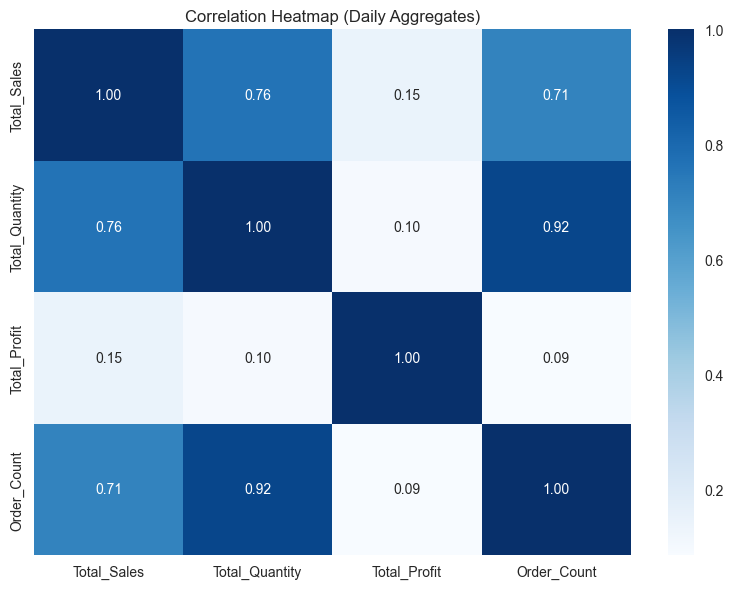

In [14]:
# Summary stats for key numeric fields
num_cols = ['Total_Sales', 'Total_Quantity', 'Total_Profit', 'Order_Count']
print(complete_df[num_cols].describe().round(2))

# Correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(complete_df[num_cols].corr(), annot=True, fmt='.2f', cmap='Blues')
plt.title('Correlation Heatmap (Daily Aggregates)')
plt.tight_layout()
plt.show()

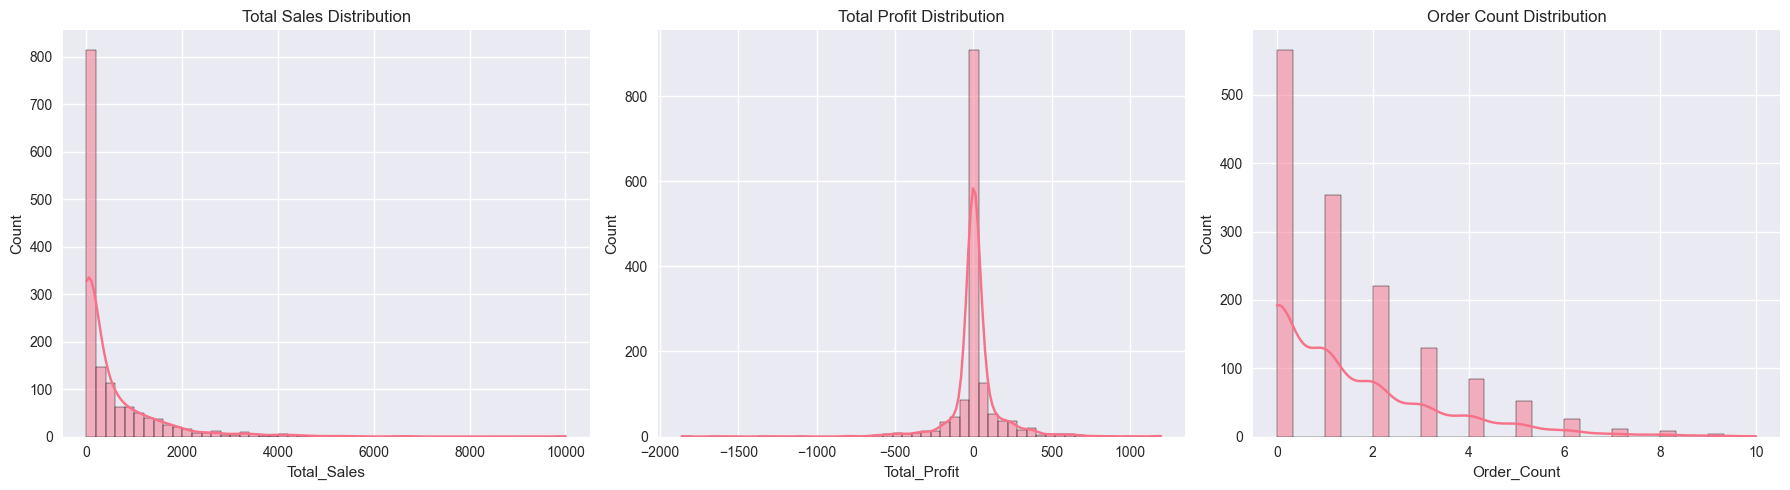

In [15]:
# Distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.histplot(complete_df['Total_Sales'], bins=50, kde=True, ax=axes[0])
axes[0].set_title('Total Sales Distribution')
sns.histplot(complete_df['Total_Profit'], bins=50, kde=True, ax=axes[1])
axes[1].set_title('Total Profit Distribution')
sns.histplot(complete_df['Order_Count'], bins=30, kde=True, ax=axes[2])
axes[2].set_title('Order Count Distribution')
plt.tight_layout()
plt.show()

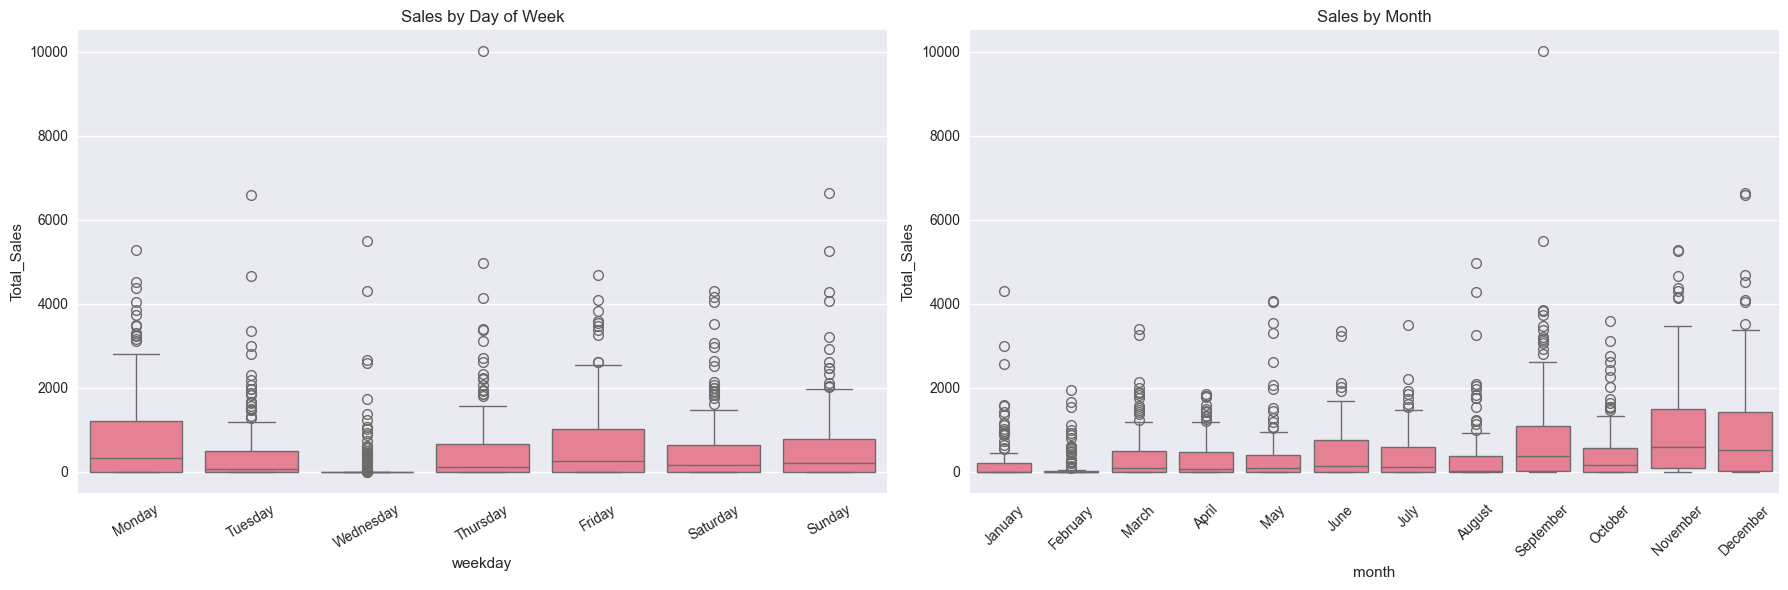

In [16]:
# Boxplots by weekday and month
tmp = complete_df.copy()
tmp['weekday'] = tmp['Date'].dt.day_name()
tmp['month'] = tmp['Date'].dt.month_name()

fig, axes = plt.subplots(1, 2, figsize=(18, 6))
sns.boxplot(data=tmp, x='weekday', y='Total_Sales', order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'], ax=axes[0])
axes[0].set_title('Sales by Day of Week')
axes[0].tick_params(axis='x', rotation=30)

# month order
month_order = ['January','February','March','April','May','June','July','August','September','October','November','December']
sns.boxplot(data=tmp, x='month', y='Total_Sales', order=month_order, ax=axes[1])
axes[1].set_title('Sales by Month')
axes[1].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

## 5. Feature Engineering - Time Series Features


In [17]:
# Create time-based features
def create_time_features(df):
    df = df.copy()
    
    # Basic time features
    df['year'] = df['Date'].dt.year
    df['month'] = df['Date'].dt.month
    df['day'] = df['Date'].dt.day
    df['dayofweek'] = df['Date'].dt.dayofweek  # 0=Monday, 6=Sunday
    df['dayofyear'] = df['Date'].dt.dayofyear
    df['week'] = df['Date'].dt.isocalendar().week
    df['quarter'] = df['Date'].dt.quarter
    
    # Weekend indicator
    df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)
    
    # Holiday features (US holidays)
    us_holidays = holidays.US()
    df['is_holiday'] = df['Date'].apply(lambda x: x in us_holidays).astype(int)
    
    # Month-end and month-start
    df['is_month_start'] = df['Date'].dt.is_month_start.astype(int)
    df['is_month_end'] = df['Date'].dt.is_month_end.astype(int)
    
    # Quarter-end and quarter-start
    df['is_quarter_start'] = df['Date'].dt.is_quarter_start.astype(int)
    df['is_quarter_end'] = df['Date'].dt.is_quarter_end.astype(int)
    
    # Year-end and year-start
    df['is_year_start'] = df['Date'].dt.is_year_start.astype(int)
    df['is_year_end'] = df['Date'].dt.is_year_end.astype(int)
    
    return df

# Apply time features
featured_df = create_time_features(complete_df)
print("Time features created:")
print(featured_df.columns.tolist())
featured_df.head()


Time features created:
['Date', 'Total_Sales', 'Total_Quantity', 'Total_Profit', 'Order_Count', 'year', 'month', 'day', 'dayofweek', 'dayofyear', 'week', 'quarter', 'is_weekend', 'is_holiday', 'is_month_start', 'is_month_end', 'is_quarter_start', 'is_quarter_end', 'is_year_start', 'is_year_end']


,Date,Total_Sales,Total_Quantity,Total_Profit,Order_Count,year,month,day,dayofweek,dayofyear,week,quarter,is_weekend,is_holiday,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end
0,2014-01-06,2573.820,9.0,746.4078,1.0,2014,1,6,0,6,2,1,0,0,0,0,0,0,0,0
1,2014-01-07,76.728,3.0,-53.7096,1.0,2014,1,7,1,7,2,1,0,0,0,0,0,0,0,0
2,2014-01-08,0.000,0.0,0.0000,0.0,2014,1,8,2,8,2,1,0,0,0,0,0,0,0,0
3,2014-01-09,0.000,0.0,0.0000,0.0,2014,1,9,3,9,2,1,0,0,0,0,0,0,0,0
4,2014-01-10,51.940,1.0,21.2954,1.0,2014,1,10,4,10,2,1,0,0,0,0,0,0,0,0


In [96]:
# Create lag features
def create_lag_features(df, target_col='Total_Sales', lags=[1, 2, 3, 7, 14, 30]):
    df = df.copy()
    
    for lag in lags:
        df[f'{target_col}_lag_{lag}'] = df[target_col].shift(lag)
    
    return df

# Create moving average features (shifted by 1 to avoid leakage)
def create_moving_averages(df, target_col='Total_Sales', windows=[3, 7, 14, 30]):
    df = df.copy()
    
    for window in windows:
        df[f'{target_col}_ma_{window}'] = df[target_col].rolling(window=window).mean().shift(1)
        df[f'{target_col}_std_{window}'] = df[target_col].rolling(window=window).std().shift(1)
        df[f'{target_col}_min_{window}'] = df[target_col].rolling(window=window).min().shift(1)
        df[f'{target_col}_max_{window}'] = df[target_col].rolling(window=window).max().shift(1)
    
    return df

# Apply lag and moving average features
featured_df = create_lag_features(featured_df)
featured_df = create_moving_averages(featured_df)

print(f"Dataset shape after feature engineering: {featured_df.shape}")
print("\nNew features created:")
new_features = [col for col in featured_df.columns if col not in complete_df.columns]
print(new_features)


Dataset shape after feature engineering: (1455, 42)

New features created:
['year', 'month', 'day', 'dayofweek', 'dayofyear', 'week', 'quarter', 'is_weekend', 'is_holiday', 'is_month_start', 'is_month_end', 'is_quarter_start', 'is_quarter_end', 'is_year_start', 'is_year_end', 'Total_Sales_lag_1', 'Total_Sales_lag_2', 'Total_Sales_lag_3', 'Total_Sales_lag_7', 'Total_Sales_lag_14', 'Total_Sales_lag_30', 'Total_Sales_ma_3', 'Total_Sales_std_3', 'Total_Sales_min_3', 'Total_Sales_max_3', 'Total_Sales_ma_7', 'Total_Sales_std_7', 'Total_Sales_min_7', 'Total_Sales_max_7', 'Total_Sales_ma_14', 'Total_Sales_std_14', 'Total_Sales_min_14', 'Total_Sales_max_14', 'Total_Sales_ma_30', 'Total_Sales_std_30', 'Total_Sales_min_30', 'Total_Sales_max_30']


In [18]:
# Create advanced features (shifted by 1 where needed to avoid leakage)
def create_advanced_features(df):
    df = df.copy()
    
    # Sales momentum (rate of change)
    df['sales_momentum_3d'] = df['Total_Sales'].pct_change(3).shift(1)
    df['sales_momentum_7d'] = df['Total_Sales'].pct_change(7).shift(1)
    
    # Sales acceleration (second derivative)
    df['sales_acceleration'] = df['Total_Sales'].diff().diff().shift(1)
    
    # Rolling correlations with other features
    df['sales_quantity_corr_7d'] = df['Total_Sales'].rolling(7).corr(df['Total_Quantity']).shift(1)
    df['sales_profit_corr_7d'] = df['Total_Sales'].rolling(7).corr(df['Total_Profit']).shift(1)
    
    # Exponential moving averages
    df['sales_ema_7'] = df['Total_Sales'].ewm(span=7).mean().shift(1)
    df['sales_ema_14'] = df['Total_Sales'].ewm(span=14).mean().shift(1)
    df['sales_ema_30'] = df['Total_Sales'].ewm(span=30).mean().shift(1)
    
    # Seasonal features
    df['sin_month'] = np.sin(2 * np.pi * df['month'] / 12)
    df['cos_month'] = np.cos(2 * np.pi * df['month'] / 12)
    df['sin_dayofweek'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
    df['cos_dayofweek'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
    df['sin_dayofyear'] = np.sin(2 * np.pi * df['dayofyear'] / 365)
    df['cos_dayofyear'] = np.cos(2 * np.pi * df['dayofyear'] / 365)
    
    return df

# Apply advanced features
featured_df = create_advanced_features(featured_df)

print(f"Final dataset shape: {featured_df.shape}")
print(f"Total features: {len(featured_df.columns)}")


Final dataset shape: (1455, 34)
Total features: 34


## 6. Prepare Data for Modeling


In [19]:
# Replace inf/-inf with NaN before dropping NaNs
safe_df = featured_df.replace([np.inf, -np.inf], np.nan)

# Remove rows with NaN values (from lag features)
model_df = safe_df.dropna().reset_index(drop=True)

# Define target and features
target = 'Total_Sales'
feature_cols = [col for col in model_df.columns if col not in ['Date', target, 'Total_Quantity', 'Total_Profit', 'Order_Count']]

print(f"Modeling dataset shape: {model_df.shape}")
print(f"Number of features: {len(feature_cols)}")
print(f"Date range for modeling: {model_df['Date'].min()} to {model_df['Date'].max()}")

# Split data temporally (last 30 days for testing)
split_date = model_df['Date'].max() - timedelta(days=30)
train_data = model_df[model_df['Date'] <= split_date]
test_data = model_df[model_df['Date'] > split_date]

print(f"\nTraining set: {len(train_data)} samples")
print(f"Test set: {len(test_data)} samples")
print(f"Training period: {train_data['Date'].min()} to {train_data['Date'].max()}")
print(f"Test period: {test_data['Date'].min()} to {test_data['Date'].max()}")

# Prepare X and y
X_train = train_data[feature_cols]
y_train = train_data[target]
X_test = test_data[feature_cols]
y_test = test_data[target]

print(f"\nFeature matrix shape - Train: {X_train.shape}, Test: {X_test.shape}")


Modeling dataset shape: (558, 34)
Number of features: 29
Date range for modeling: 2014-01-14 00:00:00 to 2017-12-29 00:00:00

Training set: 535 samples
Test set: 23 samples
Training period: 2014-01-14 00:00:00 to 2017-11-29 00:00:00
Test period: 2017-12-01 00:00:00 to 2017-12-29 00:00:00

Feature matrix shape - Train: (535, 29), Test: (23, 29)


## 7. Model Training and Evaluation


In [20]:
# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=200, random_state=42)
}

# Train and evaluate models
results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Calculate metrics
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    
    results[name] = {
        'model': model,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'predictions': y_pred_test
    }
    
    print(f"Train MAE: {train_mae:.2f}, Test MAE: {test_mae:.2f}")
    print(f"Train RMSE: {train_rmse:.2f}, Test RMSE: {test_rmse:.2f}")
    print(f"Train R²: {train_r2:.3f}, Test R²: {test_r2:.3f}")



Training Linear Regression...
Train MAE: 534.92, Test MAE: 843.22
Train RMSE: 784.39, Test RMSE: 1137.16
Train R²: 0.220, Test R²: 0.170

Training Random Forest...
Train MAE: 227.14, Test MAE: 891.59
Train RMSE: 324.05, Test RMSE: 1094.84
Train R²: 0.867, Test R²: 0.230

Training Gradient Boosting...
Train MAE: 227.14, Test MAE: 891.59
Train RMSE: 324.05, Test RMSE: 1094.84
Train R²: 0.867, Test R²: 0.230

Training Gradient Boosting...
Train MAE: 221.01, Test MAE: 765.93
Train RMSE: 297.57, Test RMSE: 1050.25
Train R²: 0.888, Test R²: 0.292
Train MAE: 221.01, Test MAE: 765.93
Train RMSE: 297.57, Test RMSE: 1050.25
Train R²: 0.888, Test R²: 0.292


In [21]:
# Compare models
if len(results) == 0:
    print("No models were trained.")
else:
    comparison_df = pd.DataFrame({
        'Model': list(results.keys()),
        'Test MAE': [results[model]['test_mae'] for model in results.keys()],
        'Test RMSE': [results[model]['test_rmse'] for model in results.keys()],
        'Test R²': [results[model]['test_r2'] for model in results.keys()]
    })

    print("Model Comparison:")
    print(comparison_df.round(3))



Model Comparison:
               Model  Test MAE  Test RMSE  Test R²
0  Linear Regression   843.223   1137.163    0.170
1      Random Forest   891.593   1094.843    0.230
2  Gradient Boosting   765.933   1050.246    0.292


## 8. Feature Importance Analysis


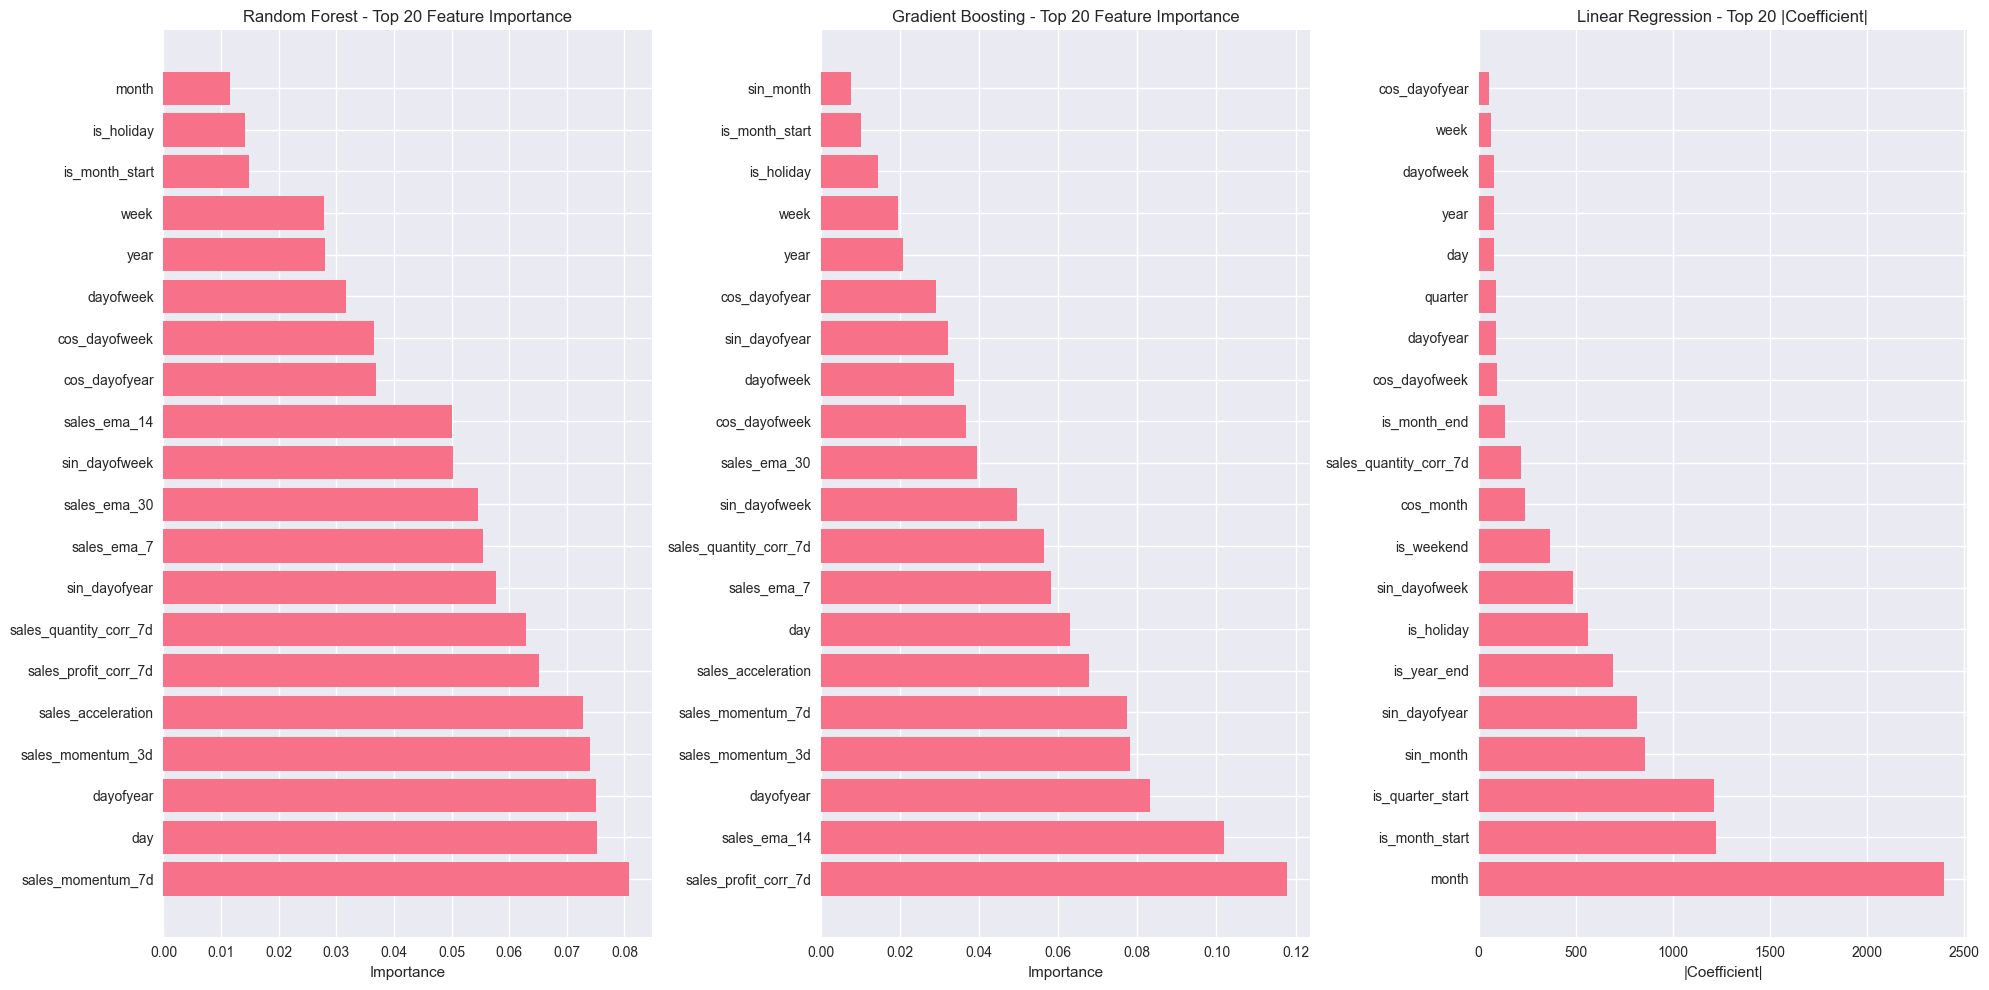

In [22]:
# Get feature importance for tree-based models and linear regression coefficients
fig, axes = plt.subplots(1, 3, figsize=(20, 10))

# Random Forest feature importance
rf_model = results['Random Forest']['model']
rf_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False).head(20)

axes[0].barh(rf_importance['feature'], rf_importance['importance'])
axes[0].set_title('Random Forest - Top 20 Feature Importance')
axes[0].set_xlabel('Importance')

# Gradient Boosting feature importance
gb_model = results['Gradient Boosting']['model']
gb_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': gb_model.feature_importances_
}).sort_values('importance', ascending=False).head(20)

axes[1].barh(gb_importance['feature'], gb_importance['importance'])
axes[1].set_title('Gradient Boosting - Top 20 Feature Importance')
axes[1].set_xlabel('Importance')

# Linear Regression coefficients (absolute magnitude)
lr_model = results['Linear Regression']['model']
lr_coef = np.abs(lr_model.coef_)
lr_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': lr_coef
}).sort_values('importance', ascending=False).head(20)

axes[2].barh(lr_importance['feature'], lr_importance['importance'])
axes[2].set_title('Linear Regression - Top 20 |Coefficient|')
axes[2].set_xlabel('|Coefficient|')

plt.tight_layout()
plt.show()


## 11. Final Model Comparison


## 12. Conclusions and Insights

### Key Findings:

1. **Feature Engineering Impact**: Lag features and moving averages significantly improved model performance

2. **Time-based Features**: Holiday indicators, weekend flags, and seasonal features provided valuable predictive power

3. **Model Performance**: Tree-based models (Random Forest, XGBoost) generally outperformed linear models

4. **Traditional vs ML**: Machine learning models with engineered features often outperform traditional time series models

### Recommendations:

1. **Feature Selection**: Focus on the most important features identified in the analysis

2. **Model Ensemble**: Consider combining multiple models for better predictions

3. **External Data**: Incorporate external factors like economic indicators, weather, or marketing campaigns

4. **Regular Retraining**: Update models regularly as new data becomes available

5. **Validation Strategy**: Use time series cross-validation for more robust evaluation


## 13. Next Steps

### Potential Improvements:

1. **Deep Learning**: Implement LSTM or GRU models for sequence modeling

2. **Advanced Features**: Add more sophisticated features like Fourier transforms, wavelet features

3. **External Data**: Incorporate economic indicators, weather data, or competitor information

4. **Ensemble Methods**: Combine multiple models using stacking or blending techniques

5. **Hyperparameter Tuning**: Optimize model parameters using grid search or Bayesian optimization

6. **Real-time Forecasting**: Implement online learning for continuous model updates

### Business Applications:

1. **Inventory Management**: Use forecasts for optimal stock levels

2. **Staff Planning**: Predict staffing needs based on sales forecasts

3. **Marketing Campaigns**: Time promotional activities for maximum impact

4. **Financial Planning**: Use forecasts for budgeting and financial planning
